# Introduction

時系列データの異常検知を行います。

時系列データの異常検知の手法はこちらのスライドに記載しました。

今回はもっともシンプルなARモデルによる異常検知を行います。


# ハンズオン1

# 各種ライブラリの取得



In [21]:
%matplotlib inline 
import numpy as np
import pylab
from pandas import read_csv
from random import gauss
from statsmodels.tsa.ar_model import AR
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import statsmodels.api as sm
import scipy.stats as st
import sys
from matplotlib import animation as ani
import sklearn.metrics as mt
plt.style.use('ggplot')

# 気温データの取得

直接HTMLから読み込んでpandas形式にしてくれる関数です。

https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_html.html

In [22]:
wave_data = read_csv('https://raw.githubusercontent.com/jamesrobertlloyd/gpss-research/master/data/tsdlr_5050/daily-minimum-temperatures-in-me-train.csv', header=None, names=["Date", "Temp"])
wave_data = wave_data.sort_values(by=['Date'])

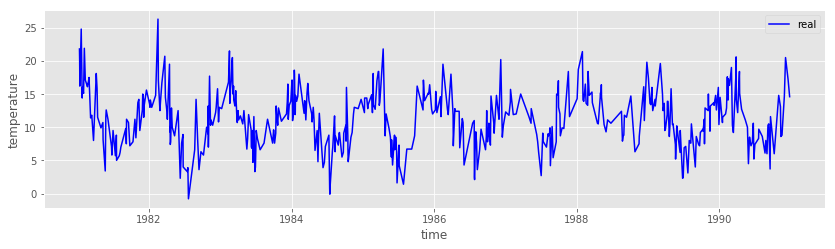

In [36]:
X_orig = wave_data["Temp"].values
X_day = wave_data["Date"].values

def show_graph(day, data, label, color="b"):
    pylab.figure(figsize=(14, 8))
    pylab.subplot(211)
    pylab.xlabel('time')
    pylab.ylabel('temperature')
    pylab.plot(day, data, color=color, label=label)
    pylab.legend(loc='upper right')
    pylab.show()
    
show_graph(X_day, X_orig, 'real')

# データの分割

- 学習データ
- 検証データ
- テストデータ

In [37]:
print(X_orig.shape)
X_train = X_orig[:300]
X_valid = X_orig[300:350]
X_test = X_orig[350:]

X_train_day = X_day[:300]
X_valid_day = X_day[300:350]
X_test_day = X_day[350:]

(500,)


# 学習データ

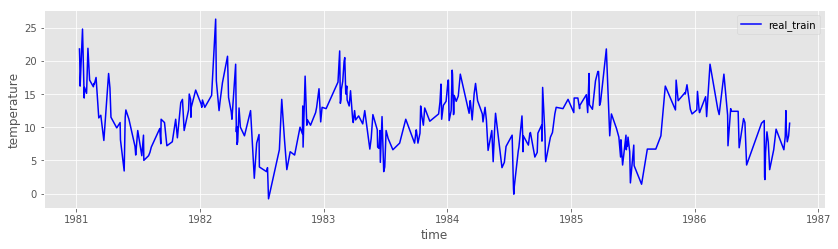

In [38]:
show_graph(X_train_day, X_train, 'real_train')

# 検証データ

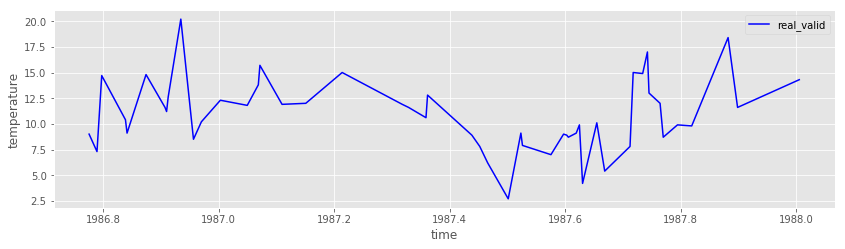

In [39]:
show_graph(X_valid_day, X_valid, 'real_valid')

# テストデータ

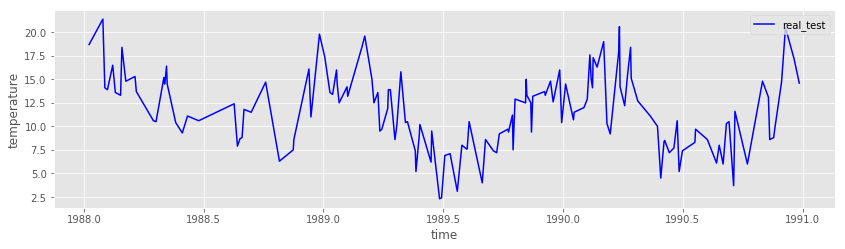

In [40]:
show_graph(X_test_day, X_test, 'real_test')

# Smooth process

- 移動平均によりスムージングして余分なノイズを除いています。下記の操作によってノイズを除去しています
 - 畳み込み処理

簡単な例を載せておきます。

計算例

[(windowサイズの総和) / windowサイズ, (windowサイズの総和{1つずらす}) / windowサイズ, (windowサイズの総和{2つずらす}) / windowサイズ]

[(1 + 2 + 3 ) / 3, (2 + 3 + 4 ) / 3, (3 + 4 + 5 ) / 3]

[2, 3, 4]


In [41]:
window_len = 3
x = np.array([1, 2, 3, 4, 5])
w = np.ones(window_len, 'd')
print('window {}'.format(w))
    
y = np.convolve( w / w.sum(), x, mode='valid')
y

window [1. 1. 1.]


array([2., 3., 4.])

In [42]:
def smooth(x, window_len=11):

    w = np.ones(window_len, 'd')
    
    y = np.convolve( w / w.sum(), x, mode='valid')
    return y

# 学習データのスムージング

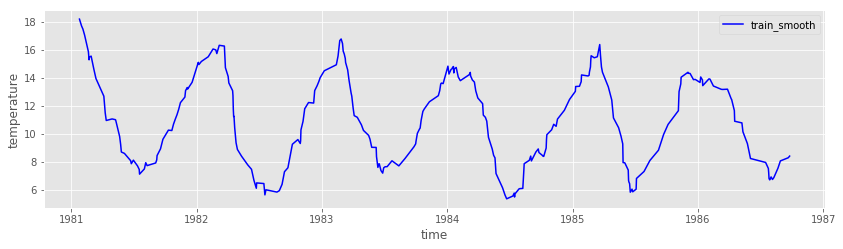

In [43]:
half_window = 5
X_smooth_train = smooth(X_train)
X_train_day_smooth = X_train_day[half_window:-half_window]

show_graph(X_train_day_smooth, X_smooth_train, 'train_smooth')

# 検証データのスムージング

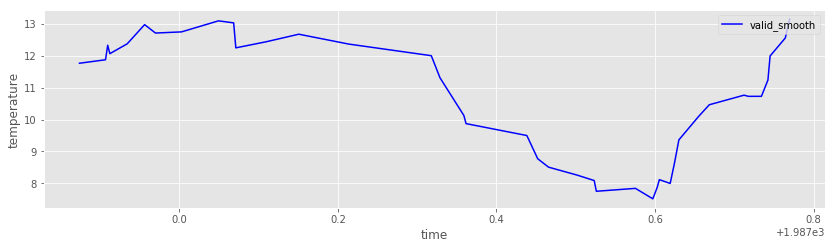

In [44]:
X_smooth_valid = smooth(X_valid)
X_valid_day_smooth = X_valid_day[half_window:-half_window]

show_graph(X_valid_day_smooth, X_smooth_valid, 'valid_smooth')

# テストデータのスムージング

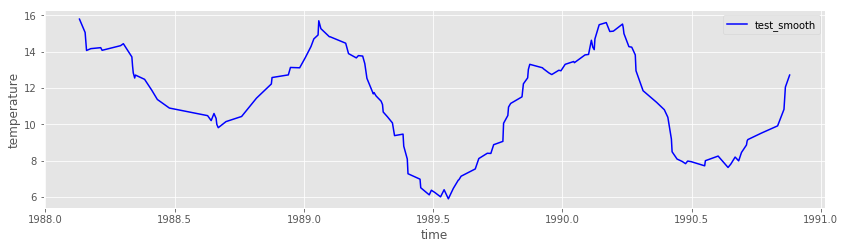

In [45]:
X_smooth_test = smooth(X_test)
X_test_day_smooth = X_test_day[half_window:-half_window]

show_graph(X_test_day_smooth, X_smooth_test, 'test_smooth')

# ハンズオン2：ARモデル

# 時間依存性について
- 時間差を考慮した自分自身との相関関係を自己相関と呼ぶ
- 自分との時間差をラグと呼ぶ

下記の図は時間を4ずらした時系列とその時系列データ同士をサンプリングして相関があるか確認している図

No handles with labels found to put in legend.


496


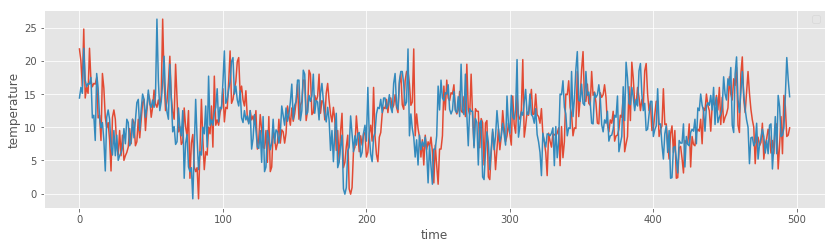

No handles with labels found to put in legend.


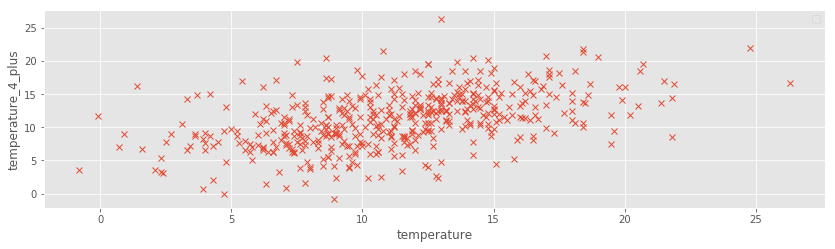

In [46]:
i = 4
print(X_orig[:-i].shape[0])

pylab.figure(figsize=(14, 8))
pylab.subplot(211)
pylab.xlabel('time')
pylab.ylabel('temperature')
pylab.plot(X_orig[:-i])
pylab.plot(X_orig[i:])
pylab.legend(loc='upper right')
pylab.show()

pylab.figure(figsize=(14, 8))
pylab.subplot(211)
pylab.xlabel('temperature')
pylab.ylabel('temperature_' + str(i) + '_plus')
pylab.plot(X_orig[:-i], X_orig[i:], 'x')
pylab.legend(loc='upper right')
pylab.show()

ラグとの相関関係を表しています。95%信頼区間を赤色で示しており、ラグが大きくなるほど相関が減っていくことが確認できます。

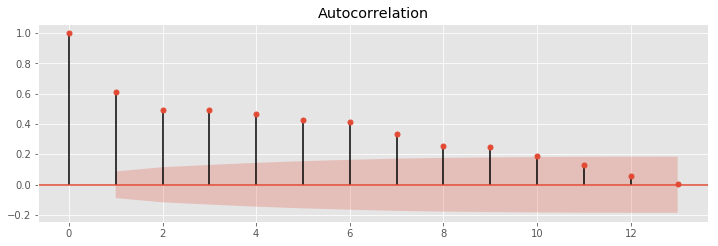

In [47]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(X_orig, lags=13, ax=ax1)

# 自己共分散

- 周期的に共分散の値が出ていることが確認できます。

No handles with labels found to put in legend.


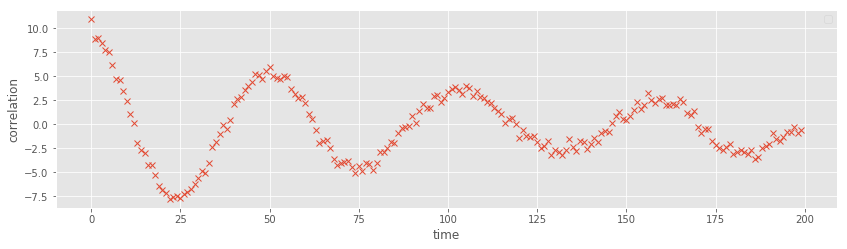

In [48]:
i = 1
self_correate = []
for i in range(200):
    i = i + 1
    a = np.array([X_orig[:-i], X_orig[i:]])
    # a_cov = np.cov(a, rowvar=0, bias=1)
    a_cov = np.cov(a)
    self_correate.append(a_cov[0][1])

pylab.figure(figsize=(14, 8))
pylab.subplot(211)
pylab.xlabel('time')
pylab.ylabel('correlation')
pylab.plot(self_correate, 'x')
pylab.legend(loc='upper right')
pylab.show()


# ARモデルの学習

- Lag: windowの幅
- Coefficients: 学習後のパラメータ
- 下記のリンクでARモデルに設定可能なパラメータが確認可能

http://www.statsmodels.org/dev/generated/statsmodels.tsa.ar_model.AR.fit.html

In [49]:
def train_autoregression(train_data):
    # train autoregression
    model = AR(train_data)
    model_fit = model.fit()
    window = model_fit.k_ar
    coef = model_fit.params
    print('Lag: %s' % model_fit.k_ar)
    print('Coefficients: %s' % model_fit.params)
    # make predictions
    print('aic {}'.format(model_fit.aic))
    return model_fit

# データの予測

- history: 過去データを保存し予測に使用
- lag: 過去データの末尾のwindowサイズ分のデータを保持
- yhat: ARモデルの予測データ

In [88]:
def predict_autoregression(model, valid_data):
    window = model.k_ar
    coef = model.params
    
    # windowサイズ分、データの末尾を取得
    history = valid_data[len(valid_data) - window:]
    history = valid_data[:window]
    history = [h for h in history]
    predictions = []

    for index, test in enumerate(valid_data):
        # 過去のデータサイズを取得
        length = len(history)
        # windowサイズ分、観測したデータを追加していく
        lag = [history[i] for i in range(length - window, length)]
        yhat = coef[0]
        for d in range(window):
            # 実測値とパラメータをかけて予測値を導出
            yhat += coef[d + 1] * lag[window - d - 1]
            # 本来は下記の式でノイズも考慮するが今回は理解を優先するため考慮しない
            # yhat += coef[d + 1] * lag[window - d - 1] + np.random.normal(0, model.sigma2, 1)
        obs = test
        predictions.append(yhat)
        history.append(obs)

    return predictions

# 学習データと検証データの予測結果

- windowサイズ分は予測に使用するのでその分ずらしている

Lag: 16
Coefficients: [ 0.83381629  1.25428311 -0.24407503  0.12534276 -0.04324986 -0.05128195
  0.04569956 -0.22667238  0.05549717  0.1230015  -0.03594741 -0.45135512
  0.56512759 -0.08477151 -0.05925277  0.00866351 -0.05619736]
aic -2.2205263349638367


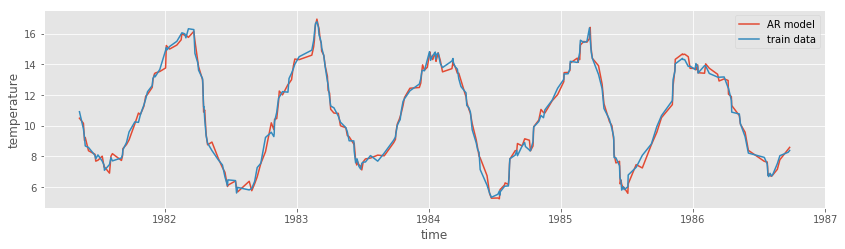

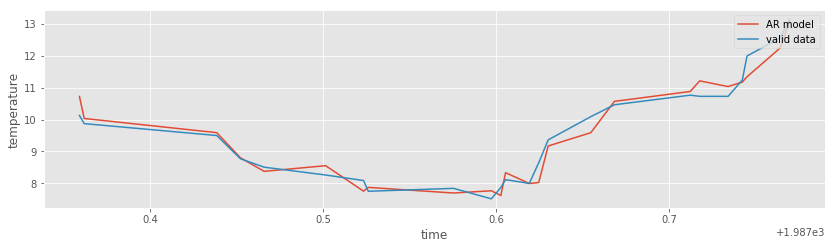

In [118]:
def show_2data_graph(day, data, compare_data, label, compare_label):
    pylab.figure(figsize=(14, 8))
    pylab.subplot(211)
    pylab.xlabel('time')
    pylab.ylabel('temperature')
    pylab.plot(day, data, label=label)
    pylab.plot(day, compare_data, label=compare_label)
    pylab.legend(loc='upper right')
    pylab.show()

model = train_autoregression(X_smooth_train)

window = model.k_ar

X_smooth_train = X_smooth_train
predictions = predict_autoregression(model, X_smooth_train)

X_smooth_valid = X_smooth_valid
predictions_valid = predict_autoregression(model, X_smooth_valid)

show_2data_graph(X_train_day_smooth[window:], predictions[window:], X_smooth_train[window:], 'AR model', 'train data')

show_2data_graph(X_valid_day_smooth[window:], predictions_valid[window:], X_smooth_valid[window:], 'AR model', 'valid data')

# Smoothなしで学習

ARモデルでは上手く模倣できない。 

Lag: 16
Coefficients: [ 4.37285592e+00  3.25969155e-01 -1.26287279e-02  2.03435257e-01
  1.46624126e-01  1.00379028e-01  1.24653027e-01 -4.86291431e-02
 -4.29029929e-02  8.15134790e-02 -2.26127786e-03  6.17743355e-02
 -5.95052681e-02  2.76461595e-03 -1.46707291e-01 -8.10205319e-02
 -4.63680997e-02]
aic 2.3113410043514073


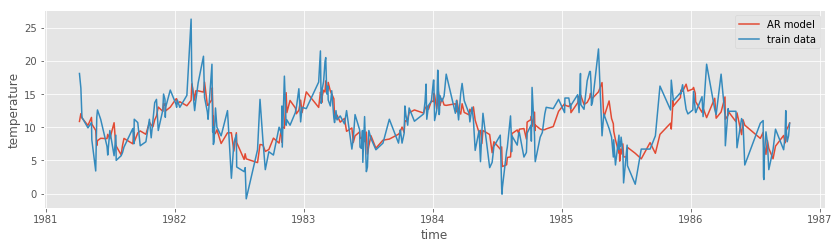

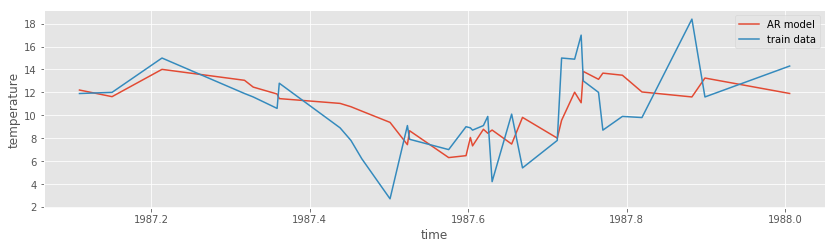

In [119]:
model_non_smooth = train_autoregression(X_train)

predictions_non_smooth = predict_autoregression(model_non_smooth, X_train)

predictions_valid_non_smooth = predict_autoregression(model_non_smooth, X_valid)

show_2data_graph(X_train_day[window:], predictions_non_smooth[window:], X_train[window:], 'AR model', 'train data')

show_2data_graph(X_valid_day[window:], predictions_valid_non_smooth[window:], X_valid[window:], 'AR model', 'train data')

# ハンズオン3: 異常データの作成

本来は元データに異常を付与する必要があるが分かりづらいのでスムージングしたデータに異常を付与

- スパイク型
- 波形変化
- レベルシフト

# スパイク型

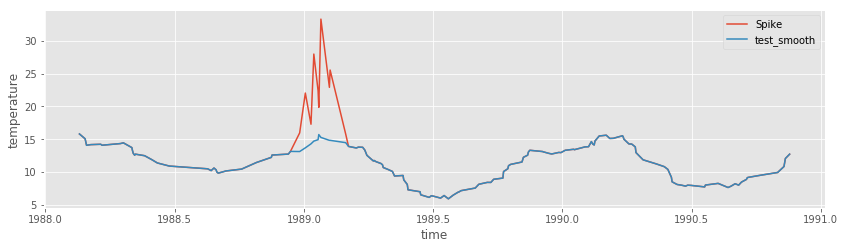

In [91]:
series = [np.abs(gauss(0.0, 7.0)) for i in range(10)]
spike_X = X_smooth_test.copy() 
spike_X[30:40] = spike_X[30:40] + series


show_2data_graph(X_test_day_smooth, spike_X, X_smooth_test, 'Spike', 'test_smooth')

# 波形変化

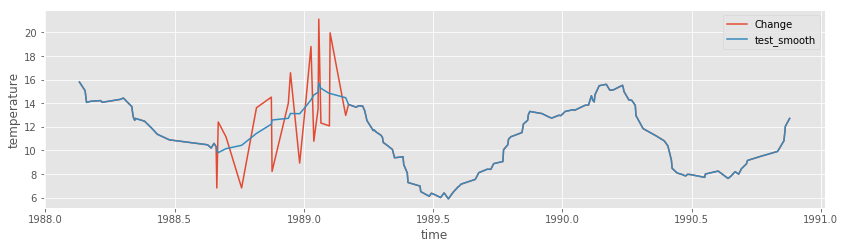

In [92]:
change_value = np.arange(0, 40, 2)
change_X = X_smooth_test.copy() 
change_X[20:40] = change_X[20:40] - (0.35 * change_X[20:40] * np.sin(change_value))

show_2data_graph(X_test_day_smooth, change_X, X_smooth_test, 'Change', 'test_smooth')

# レベルシフト

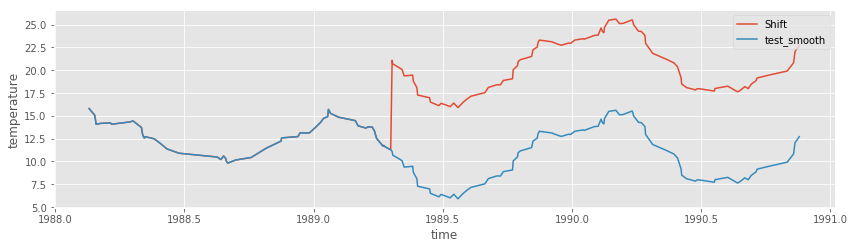

In [93]:
shift_X = X_smooth_test.copy() 
shift_X[50:] = shift_X[50:] + 10.0

show_2data_graph(X_test_day_smooth, shift_X, X_smooth_test, 'Shift', 'test_smooth')

# ハンズオン4: Anomaly Score

異常度の計算部分
- 初回の計算は分散が不定なので1で固定
- 学習データで導出した分散を使用

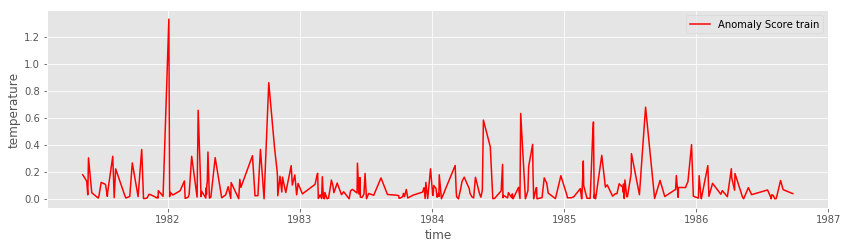

In [123]:
def calculate_mse(value, predict_value, variance=1.0):
    mse_value = [(v - p_v)**2 / variance for v, p_v in zip(value, predict_value)]
    return mse_value

window = model.k_ar
mse_value_org = calculate_mse(X_smooth_train[window:], predictions[window:])
mse_value_variance = np.mean(mse_value_org)

mse_value = calculate_mse(X_smooth_train[window:], predictions[window:], mse_value_variance)
show_graph(X_train_day_smooth[window:], mse_value_org, 'Anomaly Score train', color="r")

# 検証データの異常度

実運用では異常データは存在しないと仮定して検証データのみで閾値を設定

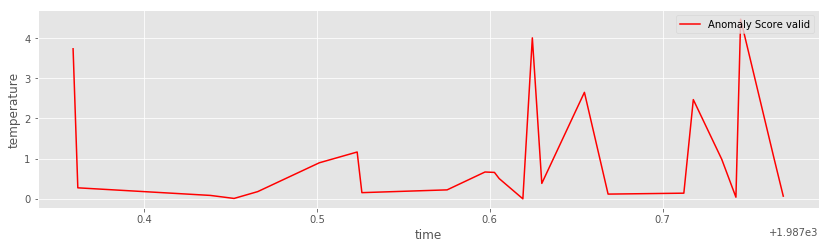

threshold value 4.468231558819185


In [110]:
mse_value_valid = calculate_mse(X_smooth_valid[window:], predictions_valid[window:], mse_value_variance)

show_graph(X_valid_day_smooth[window:], mse_value_valid, 'Anomaly Score valid', color="r")

threshold = np.max(mse_value_valid)
print("threshold value {}".format(threshold))

# Anomaly Detection

# Non Smooth Normal Data Case

スムージングしないと正常データでも異常と判断してしまう

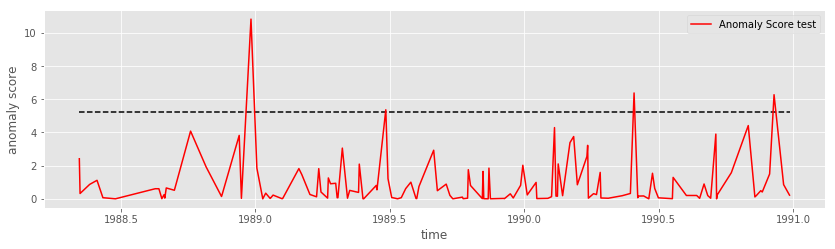

In [96]:
mse_value_org = calculate_mse(X_train[window:], predictions_non_smooth[window:])
mse_value_variance = np.mean(mse_value_org)
mse_value = calculate_mse(X_train[window:], predictions_non_smooth[window:], mse_value_variance)

mse_value_valid = calculate_mse(X_valid[window:], predictions_valid_non_smooth[window:], mse_value_variance)
threshold_non_smooth = np.max(mse_value_valid)

predictions_test_non_smooth = predict_autoregression(model_non_smooth, X_test)

mse_value_test = calculate_mse(X_test[window:], predictions_test_non_smooth[window:], mse_value_variance)

def show_graph_threshold(day, data, threshold, label, color="b"):
    pylab.figure(figsize=(14, 8))
    pylab.subplot(211)
    pylab.xlabel('time')
    pylab.ylabel('anomaly score')
    pylab.plot(day, np.repeat(threshold, day.shape[0]), 'k-', color = "k", ls = "dashed")
    pylab.plot(day, data, "r", label='Anomaly Score test')
    pylab.legend(loc='upper right')
    pylab.show()
    
show_graph_threshold(X_test_day[window:], mse_value_test, threshold_non_smooth, 'Anomaly Score test', "r")

# Normal Data Case

正常データは異常として検知しないかを確認

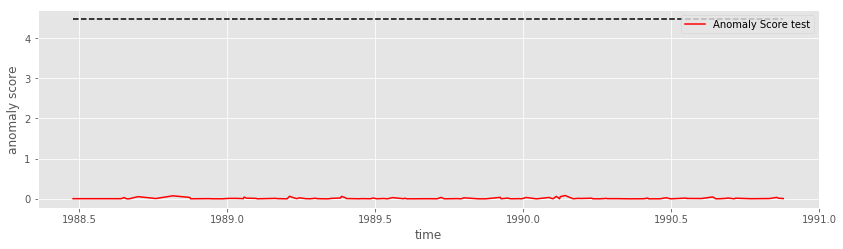

In [97]:
predictions_test = predict_autoregression(model, X_smooth_test)

mse_value_test_normal = calculate_mse(X_smooth_test[window:], predictions_test[window:], mse_value_variance)

show_graph_threshold(X_test_day_smooth[window:], mse_value_test_normal, threshold, 'Anomaly Score test', "r")

# Spike Wave Case Anomaly Score

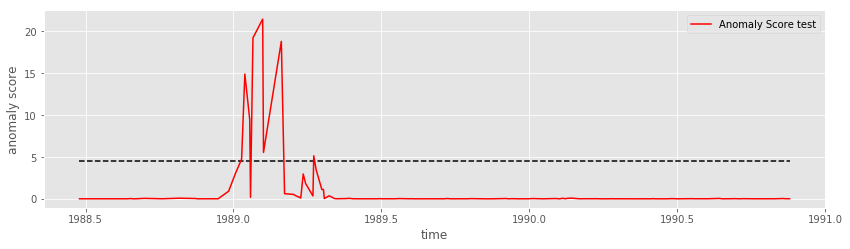

In [98]:
predictions_test = predict_autoregression(model, spike_X)

mse_value_test_spike = calculate_mse(spike_X[window:], predictions_test[window:], mse_value_variance)

show_graph_threshold(X_test_day_smooth[window:], mse_value_test_spike, threshold, 'Anomaly Score test Spike', "r")


# 実データと予測波形が異常部分は一致度合いが低いことの確認

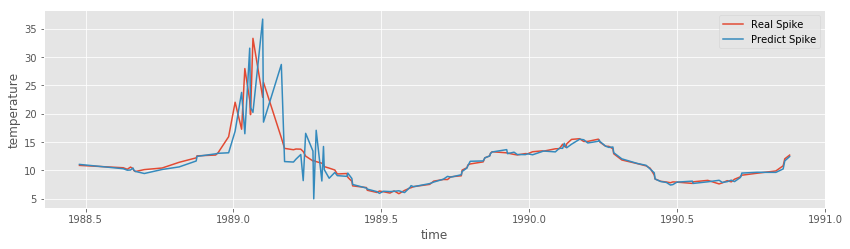

In [99]:
show_2data_graph(X_test_day_smooth[window:], spike_X[window:], predictions_test[window:], 
                 'Real Spike', 'Predict Spike')

# Change Wave Case Anomaly Score

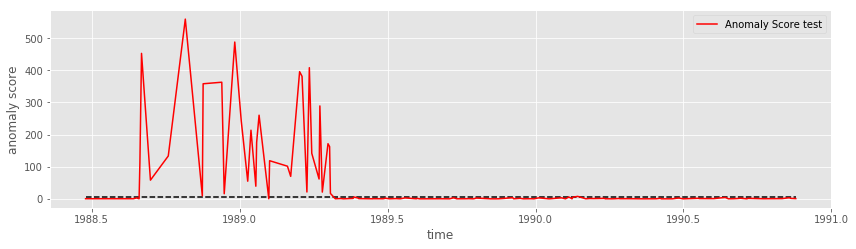

In [113]:
change_X = change_X
predictions_test = predict_autoregression(model, change_X)

mse_value_test_change_wave = calculate_mse(change_X[window:], predictions_test[window:], mse_value_variance)

show_graph_threshold(X_test_day_smooth[window:], mse_value_test_change_wave, threshold, 'Anomaly Score test change', "r")

# 実データと予測波形が異常部分は一致度合いが低いことの確認

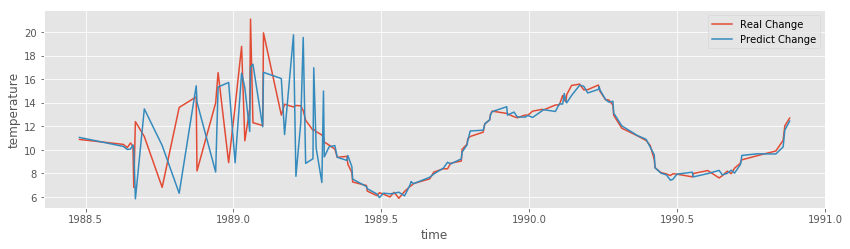

In [114]:
show_2data_graph(X_test_day_smooth[window:], change_X[window:], predictions_test[window:], 
                 'Real Change', 'Predict Change')

# Shift Wave Case Anomaly Score

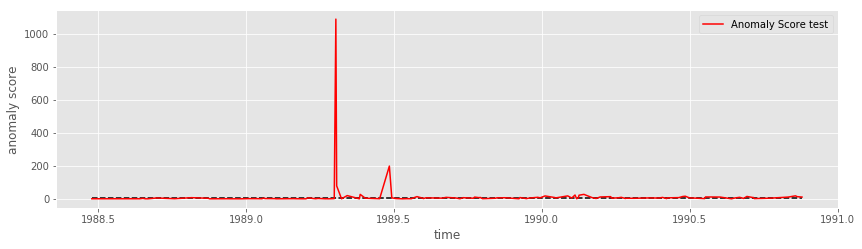

In [116]:
predictions_test = predict_autoregression(model, shift_X)

mse_value_test_shift = calculate_mse(shift_X[window:], predictions_test[window:], mse_value_variance)

show_graph_threshold(X_test_day_smooth[window:], mse_value_test_shift, threshold, 'Anomaly Score test shift', "r")

# 実データと予測波形が異常部分は一致度合いが低いことの確認

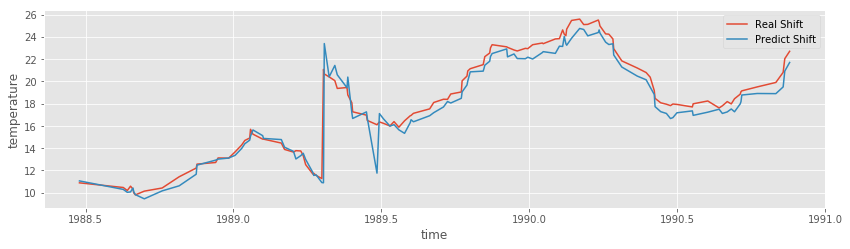

In [117]:
show_2data_graph(X_test_day_smooth[window:], shift_X[window:], predictions_test[window:], 
                 'Real Shift', 'Predict Shift')

# 正常データと異常データの分布

- 正常データの異常スコアは平均が小さく、分散も小さいことの確認
- 異常データの異常スコアは平均が大きく、分散も大きいことの確認

下記の図の軸の意味
- 縦軸が密度
- 横軸が異常度

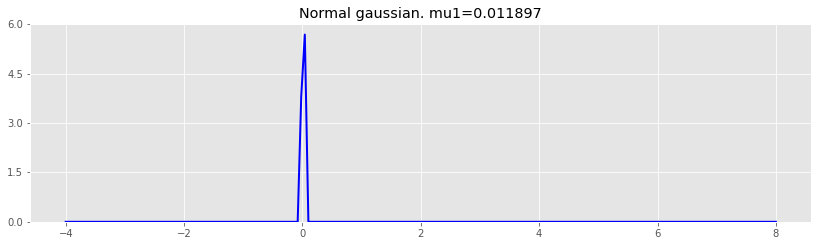

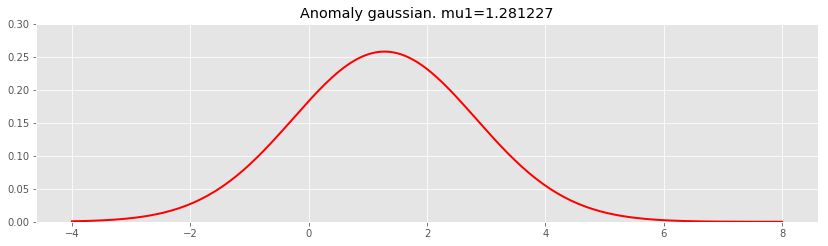

mean 0.011897365161708761
anomaly mean 1.281226865140631
std 0.016701314020203275
anomaly std 1.5444641427636754


In [104]:
mse_value_test_normal_mean = np.mean(mse_value_test_normal)
mse_value_test_normal_std = np.std(mse_value_test_normal)


anomaly_data = np.append(mse_value_test_spike[30:40], mse_value_test_change_wave[20:40])
anomaly_data = np.append(anomaly_data, mse_value_test_shift[50])

mse_value_anomaly_mean = np.mean(anomaly_data)
mse_value_anomaly_std = np.std(anomaly_data)

xmin = -4
xmax = 8

sx = 200 
xx = np.linspace(xmin, xmax, sx)

x1 = st.norm.pdf(xx, loc=mse_value_test_normal_mean, scale=mse_value_test_normal_std)

xx_anomaly = np.linspace(xmin, xmax, sx)

x2 = st.norm.pdf(xx_anomaly, loc=mse_value_anomaly_mean, scale=mse_value_anomaly_std)

plt.figure(figsize=(14, 8))
plt.subplot(211)
plt.title("Normal gaussian. mu1=%f"%(mse_value_test_normal_mean))
plt.ylim(0, 6.0)
plt.yticks(np.linspace(0, 6, 5, endpoint=True))

plt.plot(xx, x1, color='b', linewidth=2, zorder = 200)

# plt.show()
plt.figure(figsize=(14, 8))
plt.subplot(212)
plt.title("Anomaly gaussian. mu1=%f"%(mse_value_anomaly_mean))
plt.ylim(0, 0.3)

plt.plot(xx, x2, color='r', linewidth=2, zorder = 200)

plt.show()

print('mean {}'.format(mse_value_test_normal_mean))
print('anomaly mean {}'.format(mse_value_anomaly_mean))
print('std {}'.format(mse_value_test_normal_std))
print('anomaly std {}'.format(mse_value_anomaly_std))

# 正常な分布の平均を変化させた場合

下記を動作させると'ROC_curve_time_series.gif'が作成されるのでgifを確認すると動画により正常なデータの分布が変わることによるROCの変化が分かる

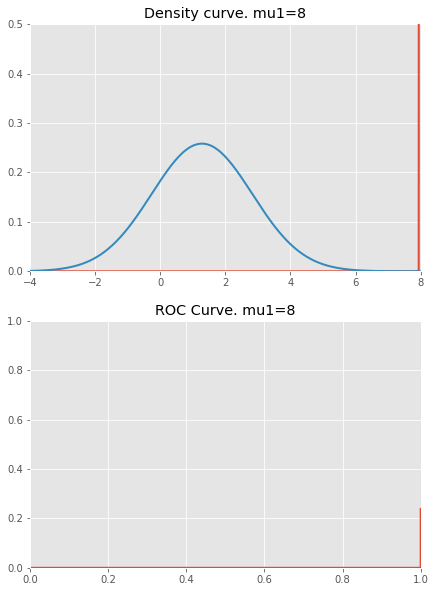

In [105]:
global mse_value_test_normal_mean_global
global mse_value_test_normal_std_global
global mse_value_anomaly_mean_global
global mse_value_anomaly_std_global

mse_value_test_normal_mean_global = mse_value_test_normal_mean
mse_value_test_normal_std_global = mse_value_test_normal_std
mse_value_anomaly_mean_global = mse_value_anomaly_mean
mse_value_anomaly_std_global = mse_value_anomaly_std

def animate(nframe):
    global num_frame
    plt.clf()
    
    xmin = -4
    xmax = 8

    # xの分割数
    sx = 200 

    # 現在位置
    pos = nframe

    # x軸生成
    xx = np.linspace(xmin, xmax, sx)

    mu1 = -4 + mse_value_test_normal_mean_global + 0.5 * pos
    mu2 = mse_value_anomaly_mean_global
    
    sd1 = mse_value_test_normal_std_global
    sd2 = mse_value_anomaly_std_global
    
    # 分布の準備
    x1 = st.norm.pdf(xx, loc=mu1, scale=sd1)
    x2 = st.norm.pdf(xx, loc=mu2, scale=sd2)
    cx1 = st.norm.cdf(xx, loc=mu1, scale=sd1)
    cx2 = st.norm.cdf(xx, loc=mu2, scale=sd2)

    # Graph描画
    plt.subplot(211)
    plt.title("Density curve. mu1=%d"%mu1)
    plt.xlim(xmin, xmax)
    plt.ylim(0,0.5)
    ln1, = plt.plot([], [], linewidth=2, zorder = 200, animated=True)
    ln1.set_data(xx, x1)
    ln2, = plt.plot([], [], linewidth=2, zorder = 200, animated=True)
    ln2.set_data(xx, x2)
    
    plt.subplot(212)
    plt.title("ROC Curve. mu1=%d"%(mu1))
    plt.xlim(0,1)
    plt.ylim(0,1)
    plt.plot(cx2, cx1, linewidth=2)
    
    return ln1, ln2

num_frame = 25
fig = plt.figure(figsize=(7,10))
anim = ani.FuncAnimation(fig, animate, frames=num_frame, blit=True)
anim.save('ROC_curve_time_series.gif', writer='imagemagick', fps=2, dpi=64)



# ROC カーブを記述し実際の性能を確認
- 異常の部分を0、正常部分を1の配列を用意
- rocに渡すスコアの引数は正常である確信度なので異常度の場合は逆数にする必要がある(sklearnの仕様なので上記の異常を0から1、正常をを1から0に変えれば逆数にしなくても動作するので好みで設定してください)

(124,)


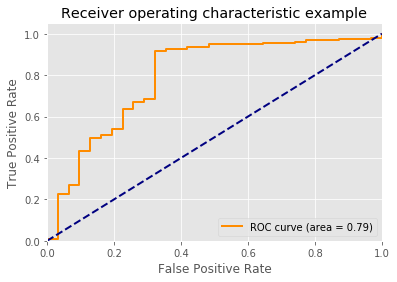

In [106]:
mse_value_test_normal = np.array(mse_value_test_normal)
mse_value_test_spike = np.array(mse_value_test_spike)
mse_value_test_change_wave = np.array(mse_value_test_change_wave)
mse_value_test_shift = np.array(mse_value_test_shift)

# Normal
answer_normal = np.ones(X_smooth_test[window:].shape)

# Spike
answer_spike = np.ones(spike_X[window:].shape)
answer_spike[30:40] = 0

# Change
answer_change = np.ones(change_X[window:].shape)
answer_change[20:40] = 0

# Shift
print(shift_X[window:].shape)
answer_shift = np.ones(shift_X[window:].shape)
answer_shift[50] = 0

anomaly_score = np.append(mse_value_test_normal, 
                          mse_value_test_spike)
anomaly_score = np.append(anomaly_score, 
                          mse_value_test_change_wave)
anomaly_score = np.append(anomaly_score, 
                          mse_value_test_shift,
                         )

answer_array = np.append(answer_normal, answer_spike)
answer_array = np.append(answer_array, answer_change)
answer_array = np.append(answer_array, answer_shift)

fpr, tpr, _ = roc_curve(answer_array, 1.0 / anomaly_score)
roc_auc = auc(fpr, tpr)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

# 発展課題

- 異常データを作成して検知できるか試して見ましょう
 - 非周期型はまだやっていないです
- ROCの性能が不十分なので上げるための方法を考えてみましょう